In [125]:
from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import csv
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

import gymnasium as gym
import time
import datetime

import sys
import os

sys.path.append('../')


from envs.random_walk import RandomWalkEnv
# from algorithms.sequence_models.old_decision_transformer.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.decision_transformer.evaluate import evaluate_on_env
from algorithms.sequence_models.old_decision_transformer.decision_transformer.trainer import DecisionTransformerTrainer
from data.random_walk_dataset import RandomWalkDataset
from data.trajectory import LimitedContextWrapper
from settings import LOG_DIR
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda')

In [120]:
rtg_target = 8

max_eval_ep_len = 20      # max len of one evaluation episode
num_eval_ep = 10          # num of evaluation episodes per iteration

batch_size = 64             # training batch size
lr = 1e-3                   # learning rate
wt_decay = 1e-4             # weight decay
warmup_steps = 10000        # warmup steps for lr scheduler

# total updates = max_train_iters x num_updates_per_iter
max_train_iters = 200
num_updates_per_iter = 100

context_len = 20        # K in decision transformer
n_blocks = 3            # num of transformer blocks
embed_dim = 128         # embedding (hidden) dim of transformer
n_heads = 1             # num of transformer heads
dropout_p = 0.1         # dropout probability

env = RandomWalkEnv()
traj_dataset = RandomWalkDataset(n_trajectories=10000)

Dataset Info:
episode_max_length: 8
reward_scale: 9
return min=-18, max=9 mean=-3.3927041554118578
state_mean: [0.50380617 0.20280483 0.09613653 0.17100488 0.02624758 0.        ]
state_std: [0.49998551 0.40208834 0.29477839 0.37651323 0.15987071 0.        ]
gamma: 1


In [121]:
class Logger:
	def __init__(self, name):
		self.name = name
		self.start_time = datetime.datetime.now().replace(microsecond=0)
		self.best_score = -np.inf
		self.iters = 0
		self.num_updates_per_iter = 0
		self.previous_csv_extra_keys = None
		
		self.log_dir = os.path.join(LOG_DIR, "dt_runs")
		
		self.save_model_path = ""
		self.save_best_model_path = ""

		if not os.path.exists(self.log_dir):
			os.makedirs(self.log_dir)
		
		self.csv_writer = None
		self.pbar = None		
		self.is_started = False

	def start(self, iterations, update_per_iter):		
		self.start_time = datetime.datetime.now().replace(microsecond=0)
		self.best_score = -np.inf
		self.iters = 0
		self.num_updates_per_iter = update_per_iter
		self.previous_csv_extra_keys = None
		
		prefix = "dt_"
		start_time_str = self.start_time.strftime("%y-%m-%d-%H-%M-%S")
		save_model_name = prefix + self.name + "_model_" + start_time_str + ".pt"
		self.save_model_path = os.path.join(self.log_dir, save_model_name)
		self.save_best_model_path = self.save_model_path[:-3] + "_best.pt"
		log_csv_name = prefix + "_log_" + start_time_str + ".csv"
		log_csv_path = os.path.join(self.log_dir, log_csv_name)
		self.csv_writer = csv.writer(open(log_csv_path, 'a', 1))
		
		self.pbar = None		
		self.is_started = True
		self.pbar = tqdm(total=iterations)

	def finish(self):
		print("=" * 60)
		print("finished training!")
		print("=" * 60)
		end_time = datetime.datetime.now().replace(microsecond=0)
		time_elapsed = str(end_time - self.start_time)
		end_time_str = end_time.strftime("%y-%m-%d-%H-%M-%S")
		
		start_time_str = self.start_time.strftime("%y-%m-%d-%H-%M-%S")

		print("started training at: " + start_time_str)
		print("finished training at: " + end_time_str)
		print("total training time: " + time_elapsed)
		print("best score: " + format(self.best_score, ".5f"))
		print("saved max d4rl score model at: " + self.save_best_model_path)
		print("saved last updated model at: " + self.save_model_path)
		print("=" * 60)

		self.is_started = False
		self.csv_writer.close()

	# todo later make it generic so that we can log whatever
	def log(self, model, mean_action_loss, eval_avg_reward, important=set(), **kwargs):		
		if not self.is_started:
			raise Exception("call .start() first")

		if self.previous_csv_extra_keys is None:
			self.previous_csv_extra_keys = list(kwargs.keys())
			csv_header = (["duration", "num_updates", "action_loss", "eval_avg_reward", "best_score", *kwargs.keys()])
			self.csv_writer.writerow(csv_header)
		elif set(self.previous_csv_extra_keys) != set(kwargs.keys()):
			raise Exception(f"expected {set(self.previous_csv_extra_keys)} keys but passed {set(kwargs.keys())}. Maybe call finish?")
		
		self.iters += 1
		time_elapsed = str(datetime.datetime.now().replace(microsecond=0) - self.start_time)
		total_updates = self.iters * self.num_updates_per_iter
				
		log_str = '\n'.join([
			"=" * 60,
			"time elapsed: " + time_elapsed,
			"num of updates: " + str(total_updates),
			"action loss: " +  format(mean_action_loss, ".5f"),
			"eval avg reward: " + format(eval_avg_reward, ".5f"),
			"best score: " + format(self.best_score, ".5f"),
			*[key + " " + format(value, ".5f") for key, value in kwargs.items()]
		])

		log_data = [time_elapsed, total_updates, mean_action_loss,
					eval_avg_reward, self.best_score] + [kwargs[key] for key in self.previous_csv_extra_keys]
		self.csv_writer.writerow(log_data)
		if eval_avg_reward >= self.best_score:
			print('achieved average reward: ', eval_avg_reward)
			print("saving max score model at: " + self.save_best_model_path)

			torch.save(model.state_dict(), self.save_best_model_path)
			self.best_score = eval_avg_reward
	
		print("saving current model at: " + self.save_model_path)
		torch.save(model.state_dict(), self.save_model_path)
		

		self.pbar.set_description(' '.join([
			f'Loss={mean_action_loss}',
			f'Best_Score={self.best_score}',
			*[f'{key}={value:.5f}' for key, value in kwargs.items() if key in important]
		]))
		
		self.pbar.update(1)
		
		print(log_str)

In [122]:
state_dim = traj_dataset.state_dim()
act_dim = traj_dataset.action_dim()

dataset = LimitedContextWrapper(traj_dataset, context_len=context_len)
logger = Logger(name='random-walk')

model = DecisionTransformer(
			state_dim=state_dim,
			act_dim=act_dim,
			n_blocks=n_blocks,
			h_dim=embed_dim,
			context_len=context_len,
			n_heads=n_heads,
			drop_p=dropout_p,
		).to(device)
  
optimizer = torch.optim.AdamW(
					model.parameters(), 
					lr=lr, 
					weight_decay=wt_decay
				)

scheduler = torch.optim.lr_scheduler.LambdaLR(
		optimizer,
		lambda steps: min((steps+1)/warmup_steps, 1)
	)

print("number of parameters", sum(np.prod(param.shape) for param in model.parameters()))


traj_data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
data_iter = iter(traj_data_loader)

loss_fn = nn.MSELoss(reduction='mean')

logger.start(iterations=max_train_iters, update_per_iter=num_updates_per_iter)

for i_train_iter in range(max_train_iters):

	log_action_losses = []	
	model.train()
 
	for _ in range(num_updates_per_iter):
		try:
			timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)
		except StopIteration:
			data_iter = iter(traj_data_loader)
			timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)

		timesteps = timesteps.to(device)	# B x T
		states = states.to(device)			# B x T x state_dim
		actions = actions.to(device)		# B x T x act_dim
		returns_to_go = returns_to_go.to(device).unsqueeze(dim=-1) # B x T x 1
		traj_mask = traj_mask.to(device)	# B x T

		action_target = torch.clone(actions).detach().to(device)
	
		state_preds, action_preds, return_preds = model.forward(
														timesteps=timesteps,
														states=states,
														actions=actions,
														returns_to_go=returns_to_go
													)
		# only consider non padded elements
		action_preds = action_preds.view(-1, act_dim)[traj_mask.view(-1,) > 0]
		action_target = action_target.view(-1, act_dim)[traj_mask.view(-1,) > 0]

		# todo maybe MSE is not the best choice for the discrete actions? Do CrossEntropy
		action_loss = loss_fn(action_preds, action_target)

		optimizer.zero_grad()
		action_loss.backward()
		torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
		optimizer.step()
		scheduler.step()

		log_action_losses.append(action_loss.detach().cpu().item())

	# todo evaluate on multiple rtg
	# evaluate on env
	results = evaluate_on_env(model=model, traj_dataset=traj_dataset,
							  device=device,context_len=context_len,
							  env=env, rtg_target=rtg_target,
							  num_eval_ep=num_eval_ep, max_test_ep_len=max_eval_ep_len)
	logger.log(model=model,
			   mean_action_loss=np.mean(log_action_losses),
			   eval_avg_reward=results['eval/avg_reward'],
			   eval_avg_ep_len=results['eval/avg_ep_len'],
			   grad_norm=max(torch.norm(param.grad) for param in model.parameters() if param.grad is not None),
			   lr=optimizer.param_groups[0]['lr'],
			   important={"grad_norm", "lr"})

logger.finish()

number of parameters 1123085


  0%|          | 0/200 [00:00<?, ?it/s]

achieved average reward:  -8.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk_model_24-05-08-04-49-27_best.pt
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk_model_24-05-08-04-49-27.pt
time elapsed: 0:00:02
num of updates: 100
action loss: 0.28848
eval avg reward: -8.00000
best score: -inf
eval_avg_ep_len 8.00000
grad_norm 0.18789
lr 0.00001
achieved average reward:  6.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk_model_24-05-08-04-49-27_best.pt
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk_model_24-05-08-04-49-27.pt
time elapsed: 0:00:03
num of updates: 200
action loss: 0.15953
eval avg reward: 6.00000
best score: -8.00000
eval_avg_ep_len 4.00000
grad_norm 0.15029
lr 0.00002
saving current model at: /home/shayan/projects/RL-credit-assignment-

AttributeError: '_csv.writer' object has no attribute 'close'

In [123]:
env = RandomWalkEnv(verbose=True)

evaluate_on_env(
	model=model,
	traj_dataset=traj_dataset,
	device=device,
	context_len=context_len,
	env=env,
	rtg_target=rtg_target,
	num_eval_ep=num_eval_ep
)

reset. node: 0
reset. node: 0
node: 0 action: 3
node: 3 action: 5
reset. node: 0
node: 0 action: 3
node: 3 action: 5
reset. node: 0
node: 0 action: 3
node: 3 action: 5
reset. node: 0
node: 0 action: 3
node: 3 action: 5
reset. node: 0
node: 0 action: 3
node: 3 action: 5
reset. node: 0
node: 0 action: 3
node: 3 action: 5
reset. node: 0
node: 0 action: 3
node: 3 action: 5
reset. node: 0
node: 0 action: 3
node: 3 action: 5
reset. node: 0
node: 0 action: 3
node: 3 action: 5
reset. node: 0
node: 0 action: 3
node: 3 action: 5


{'eval/avg_reward': 8.0, 'eval/avg_ep_len': 2.0}

Text(0, 0.5, 'rtg_result')

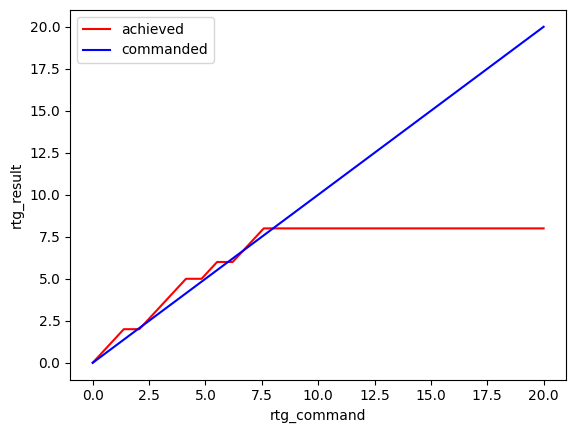

In [127]:
rtg_command = np.linspace(0, 20, 30)
env = RandomWalkEnv()

rtg_result = []

for rtg in rtg_command:
	res = evaluate_on_env(
		model=model,
		traj_dataset=traj_dataset,
		device=device,
		context_len=context_len,
		env=env,
		rtg_target=rtg,
		num_eval_ep=num_eval_ep
	)
	rtg_result.append(res['eval/avg_reward'])

plt.plot(rtg_command, rtg_result, 'r')
plt.plot(rtg_command, rtg_command, 'b')
plt.legend(["achieved", "commanded"])
plt.xlabel("rtg_command")
plt.ylabel("rtg_result")